In [42]:
import numpy as np
import time
import pandas as pd
from scipy.stats import qmc, norm
import math
import pandas as pd
pd.options.display.float_format = '{:,.4f}'.format
import matplotlib.pyplot as mp

In [100]:
S0 = 100
K = 100
r = 0.05
sigma = 0.1

mu_jump = -0.005
sigma_jump = 0.1
lambda_jump = 0.75

kappa = np.exp(mu_jump + 0.5 * sigma_jump ** 2) - 1

In [44]:
T = 1
N = 256
dt = T / N
sqrt_dt = np.sqrt(dt)

### Control Variates

In [233]:
def geom_control_function(S0, r, sigma, T, N):
    
    n_pil = 1000
    np.random.seed(1)

    res_control_pilot = np.zeros(n_pil)
    res_sample_pilot = np.zeros(n_pil)

    for i in range(n_pil):
        S = np.zeros(N + 1)
        S[0] = S0
        
        U = np.random.normal()
        J = 1
        
        if U < lambda_jump * dt:
            J = np.random.lognormal(mean = mu_jump, sigma = sigma_jump)

        for j in range(1, N + 1):
           # S[j] = S[j-1] * (1 + (r - lambda_jump * kappa) * dt + (sigma * math.sqrt(dt) * np.random.normal(0, 1)))
            S[j] = S[j-1] * math.exp((r - (sigma*sigma)/2) * dt + 
                                     sigma * math.sqrt(dt) * np.random.normal(0, 1))

        S = np.delete(S, 0)

        geo_avg = np.exp(np.log(S).mean())
        arith_avg = S.mean()

        res_control_pilot[i] = np.exp(-1 * r * T) * max(geo_avg - K, 0)
        res_sample_pilot[i] = np.exp(-1 * r * T) * max(arith_avg - K, 0)  
    
    a = np.log(S0) + (r - (sigma**2 / 2)) * T * (N + 1) / (2*N)
    b = (sigma**2) * (T * (N+1) * (2*N + 1)) / (6 * N*N)

    d1 = (-1 * np.log(K) + a + b) / math.sqrt(b)
    d2 = d1 - math.sqrt(b)

    phi_d1 = norm.cdf(d1)
    phi_d2 = norm.cdf(d2)

    mu_g_analytic = np.exp(-1 * r * T) * (np.exp(a + b/2)*phi_d1 - K * phi_d2)
    beta_estimate = np.cov(res_control_pilot, res_sample_pilot)[0][1] / np.var(res_control_pilot)
    
    return mu_g_analytic, beta_estimate

def european_control_function(S0, r, sigma, T, N):
    
    def black_scholes_call(S0, K, T, r, sigma):
        # Calculate d1 and d2
        d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)

        # Calculate the call option price using the Black-Scholes formula
        call_price = S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

        return call_price
    
    n_pil = 1000
    np.random.seed(1)

    res_control_pilot = np.zeros(n_pil)
    res_sample_pilot = np.zeros(n_pil)

    for i in range(n_pil):
        S = np.zeros(N + 1)
        S[0] = S0

        for j in range(1, N + 1):
            S[j] = S[j-1] * (1 + (r - lambda_jump * kappa) + (sigma * math.sqrt(dt) * np.random.normal(0, 1)))
            #S[j] = S[j-1] * math.exp((r - (sigma*sigma)/2) * dt + 
            #                         sigma * math.sqrt(dt) * np.random.normal(0, 1))

        S = np.delete(S, 0)

        #geo_avg = np.exp(np.log(S).mean())
        euro = S[-1]
        arith_avg = S.mean()

        res_control_pilot[i] = np.exp(-1 * r * T) * max(euro - K, 0)
        res_sample_pilot[i] = np.exp(-1 * r * T) * max(arith_avg - K, 0)  
        
        mu_g_analytic = black_scholes_call(S0, K, T, r, sigma)
        beta_estimate = np.cov(res_control_pilot, res_sample_pilot)[0][1] / np.var(res_control_pilot)

        return mu_g_analytic, beta_estimate
    

def control_variates(n):
    
    mu_g_analytic, beta_estimate = geom_control_function(S0, r, sigma, T, N)
    
    result = np.zeros(n)
    result_control = np.zeros(n)
    stocks = np.zeros(n)
    
    for i in range(n):
        S = np.zeros(N + 1)
        S[0] = S0
        
        U = np.random.normal()
        J = 1
        
        if U < lambda_jump * dt:
            J = np.random.lognormal(mean = mu_jump, sigma = sigma_jump)

        for j in range(1, N + 1):
            #S[j] = S[j-1] * (1 + (r - lambda_jump * kappa) * dt + (sigma * math.sqrt(dt) * np.random.normal(0, 1)) + (J-1))
            S[j] = S[j-1] * math.exp((r - (sigma*sigma)/2) * dt + 
                                     sigma * math.sqrt(dt) * np.random.normal(0, 1))
            
        S = np.delete(S, 0)

        geo_avg = np.exp(np.log(S).mean())
        arith_avg = S.mean()

        control = np.exp(-1 * r * T) * max(geo_avg - K, 0)
        result[i] = np.exp(-1 * r * T) * max(arith_avg - K, 0)
        result_control[i] = result[i] + beta_estimate * (mu_g_analytic - control)
        stocks[i] = S[-1]
        
    return result_control

In [46]:
def payoff_european(S, K, call = True):
    if call:
        return np.maximum(S[-1] - K, 0)
    else:
        return np.maximum(K - S[-1], 0)

def payoff_asian(S, K, likelihoods = None, call = True):
    if call:
        return np.maximum(S.mean(axis = 0) - K, 0)
    else:
        return np.maximum(K - S.mean(axis = 0), 0)
    
def payoff_asian_importance(S, likelihood_ratio = 0.5, call=True):
    raw_payoff = np.maximum(S.mean(axis=0) - K, 0) if call else np.maximum(K - S.mean(axis=0), 0)
    return raw_payoff * likelihood_ratio

In [47]:
def control_variate_asian_asset(S_i, n):
    Z = np.random.normal(size=n)
    S_new = S_i * (1 + r * dt + sigma * sqrt_dt * Z)
    return S_new

def payoff_asian_cv(S):
    """
    Returns control variate adjusted payoff.
    S: shape (N, M) array of asset prices
    """
    N, M = S.shape
    avg_price = S.mean(axis=1)
    V = np.exp(-r * T) * np.maximum(avg_price - K, 0)

    S_sum = S.sum(axis=1)
    S_star = np.mean(S_sum)

    cov = np.cov(V, S_sum, bias=True)[0, 1]
    var = np.var(S_sum)
    alpha = cov / var if var > 0 else 0.0

    V_cv = V - alpha * (S_sum - S_star)
    return V_cv


In [48]:
def quasi_brownian_asset(S_i, n):
    Z = quasi_random_normal_samples(n)
    return S_i * (1 + r * dt + sigma * sqrt_dt * Z)

def brownian_asset(S_i, n):
    Z = np.random.normal(loc=0, scale = 1, size = n)    
    return S_i * (1 + r * dt + sigma * sqrt_dt * Z)

def antithetic_brownian_asset(S_i, n):
    Z1 = np.random.normal(size = (int) (n/2))
    Z2 = -Z1
    
    Z = np.empty((Z1.size + Z2.size,), dtype=Z1.dtype)
    Z[0::2] = Z1
    Z[1::2] = Z2
    
    return S_i * (1 + r * dt + sigma * sqrt_dt * Z)

def brownian_asset_importance_sampling(S_i, n, mu_shift=0.2):
    Z = np.random.normal(loc=mu_shift, size=n)
    S_path = S_i * (1 + r * dt + sigma * sqrt_dt * Z)
    
    # Likelihood ratio for each Z sample
    likelihood_ratio = np.exp(-mu_shift * Z + 0.5 * mu_shift**2)
    
    return S_path, likelihood_ratio

In [209]:
def mc_asian_importance_sampling(S0, K, r, sigma, dt, mu_shift=0.1, n_sim = 1, n_steps = 1, ):
    payoffs = []
    for _ in range(n_sim):
        Z = np.random.normal(loc=mu_shift, scale=1.0, size=n_steps)
        S_path = S0 * np.exp(np.cumsum((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z))
        S_path = np.insert(S_path, 0, S0)
        avg_price = np.mean(S_path)
        payoff = max(avg_price - K, 0)

        # Likelihood ratio (change of measure)
        likelihood = np.exp(-mu_shift * np.sum(Z) + 0.5 * mu_shift**2 * n_steps)
        weighted_payoff = np.exp(-r * T) * payoff * likelihood
        payoffs.append(weighted_payoff)
        
    return cumulative_mean_std(payoffs)

In [50]:
def payoff_asian_importance(S, random_sum, mu_shift, n_steps):
    raw_payoff = np.maximum(S.mean(axis=0) - K, 0)
    
    likelihoods = -mu_shift * random_sum + 0.5 * mu_shift**2 * n_steps
    
    return raw_payoff * np.exp(likelihoods)

def importance_sampled_normal(size = 0, mu_shift=0.5):
    Z_shifted = np.random.normal(loc=mu_shift, scale=1)
    likelihood_ratio = np.exp(-mu_shift * Z_shifted + 0.5 * mu_shift**2)
    
    return Z_shifted, likelihood_ratio

def GBM_importance(S_i, r, sigma, dt, sqrt_dt, mu_shift=0.5):
    Z, likelihood_ratio = importance_sampled_normal(size=1, mu_shift=mu_shift)
    S_new = S_i * (1 + r * dt + sigma * sqrt_dt * Z)
    return S_new, Z

def run_monte_carlo_IS(S0, K, r, sigma, T, N, n, payoff_function, method, mu_shift=0.5):
    S = np.full((n, N), S0)
    likelihoods = np.ones(n)

    for i in range(1, N):
        S[:, i], new_likelihoods = method(S[:, i - 1], n, mu_shift=mu_shift)
        likelihoods *= new_likelihoods  # Multiply likelihoods across time steps

    print(S[:, -1])
        
    payoffs = payoff_function(S, likelihoods)
    return np.exp(-r * T) * payoffs.mean(), payoffs.std() / np.sqrt(n)


### Importance Sampling

In [256]:
def quasi_Sobol(n, dim):
    sampler = qmc.Sobol(d=dim, scramble=True)
    u = sampler.random(n)
    z = norm.ppf(u)
    return z

def standard_normal(N, M):
    return np.random.normal(loc = 0, scale = 1.0, size = (N, M))
    

def GBM(S, r, sigma, dt, sqrt_dt, Z):
    return S * np.exp((r - 0.5 * sigma**2) * dt + sigma * sqrt_dt * Z)

def MertonJump(S, r, sigma, dt, sqrt_dt, Z):
    
    U = np.random.uniform()
    J = 1
    
    if U < lambda_jump * dt:
        J = np.random.lognormal(mean = mu_jump, sigma = sigma_jump)     
        
    return S * (1 + r * dt + sigma * sqrt_dt * Z + (J-1))
    

def antithetic_GBM(S, r, sigma, dt, sqrt_dt, Z):
    return S * np.exp((r - 0.5 * sigma**2) * dt - sigma * sqrt_dt * Z)

def gbm_faster(S, r, sigma, dt, sqrt_dt):
    return S * np.exp((r - 0.5 * sigma**2) * dt + sigma * sqrt_dt * np.random.normal())


def run_monte_carlo(S0, K, r, sigma, T, M, N, payoff_function, method = GBM, sample_method = standard_normal, antithetic = True, mu_shift = 0):
    
    dt = T / M
    sqrt_dt = np.sqrt(dt)
    
    dimension = 1
    
    if antithetic:
        dimension = 2
    
    payoffs = np.zeros( (int) (dimension * N) )
    random_sum = 0
    
    if sample_method == quasi_Sobol:
        Z = sample_method(N, M)
        
    prices = np.zeros(N)
    std_devs = np.zeros(N)
    
    for i in range(N):
        S = S0
        path = [S]
        for j in range(M):
            
            if sample_method == quasi_Sobol:
                S = method(S, r, sigma, dt, sqrt_dt, Z[i, j])
            elif mu_shift != 0:
                S, new_likelihoods = method(S, r, sigma, dt, sqrt_dt, mu_shift=mu_shift)
                random_sum += new_likelihoods
                #print(S)
                
            else:
                S = method(S, r, sigma, dt, sqrt_dt, np.random.normal())
                #print(S)
                
            #S = S * np.exp((r - 0.5 * sigma**2) * dt + sigma * sqrt_dt * Z[i, j])
            path.append(S)
        
        if mu_shift != 0:
            payoffs[i] = payoff_function(np.array(path), random_sum, mu_shift, N)
        else:
            payoffs[i] = payoff_function(np.array(path), K)

    
    if antithetic:
        
        for i in range(N):
            S = S0
            path = [S]
            for j in range(M):
                
                if sample_method == quasi_Sobol:
                    S = method(S, r, sigma, dt, sqrt_dt, Z[i, j])
                else:
                    S = method(S, r, sigma, dt, sqrt_dt, np.random.normal())
                    
                #S = S * np.exp((r - 0.5 * sigma**2) * dt + sigma * sqrt_dt * Z[i, j])
                path.append(S)


            payoffs[i + N] = payoff_function(np.array(path), K)
    
        
    price = np.exp(-r * T) * payoffs
    return cumulative_mean_std(price)
    #return np.mean(price), np.std(price) / np.sqrt(dimension * N)
    
def cumulative_mean_std(x):
    x = np.asarray(x)
    n = len(x)

    means = np.zeros(n)
    stds = np.zeros(n)
    
    mean = 0.0
    M2 = 0.0

    for i in range(n):
        delta = x[i] - mean
        mean += delta / (i + 1)
        delta2 = x[i] - mean
        M2 += delta * delta2

        means[i] = mean
        if i > 0:
            stds[i] = np.sqrt(M2 / i) / np.sqrt(i)
        else:
            stds[i] = 0.0  # Standard deviation is 0 for the first point

    return means, stds


def run_experiment(method = GBM, payoff_function = payoff_asian, num_trials = 10, base = 2, 
                   sample_method = standard_normal, antithetic = False, cv = False, baseline = False, 
                   mu_shift = 0, K = 100, r = 0.05, simulation_size = 10000):
        
    v = np.zeros(simulation_size)
    std_devs = np.zeros_like(v, dtype = np.float64)
    times = np.zeros_like(v, dtype = np.float64)

    start_time = time.time()
        
    if mu_shift != 0:
            
        v, std_devs = mc_asian_importance_sampling(S0, K, r, sigma, dt, mu_shift=mu_shift, n_sim = simulation_size, n_steps = N)
            
    elif cv:
        cv_samples = control_variates(simulation_size)
        v, std_devs = cumulative_mean_std(cv_samples)
        
    else:
        v, std_devs = run_monte_carlo(S0, K, r, sigma, T, N, simulation_size, 
                                            payoff_function = payoff_function, method = method,
                                            sample_method = sample_method, antithetic = antithetic, mu_shift = mu_shift)

    running_time = time.time() - start_time
        
    return (v, std_devs, running_time)

def format_data(data, decay = 2):
    df = pd.DataFrame(np.array(data).T)
    df.index = decay ** (df.index + 3)
    df.index.name = "Num Samples"
    df.columns = {"Option Price (V)", "MOE", "Runtime"}
    
    return df

def plot_results(data, title = "Option Price NOS", true_v = 3.61873217, start = 0, end = 10000):
    mean = data[0][start:end]
    margin = data[1][start:end]

    x = np.arange(len(mean)) + 3

    mp.plot(x, mean, label='Mean', color='blue')
    #mp.plot(abs(mean - true_v), label = "Error", color = 'green')
    mp.fill_between(x, mean - margin, mean + margin, color='blue', alpha=0.2, label='Margin of Error')
    
    mp.axhline(y=true_v, color='red', linestyle=':', linewidth=2, label='Estimated Price')

    # Styling
    mp.title(title)
    mp.xlabel('Number of Simulations (Log Scale)')
    mp.ylabel('Option Value (V)')
    mp.legend(loc='upper right')
    mp.grid(True)
    mp.show()
    

In [15]:
format_data(run_experiment(baseline = True, num_trials = 7, base = 10))

,Runtime,MOE,Option Price (V)
Num Samples,,,
8,3.5669,0.1329,2.0132
16,3.6661,0.0426,20.5676
32,3.6262,0.0133,203.2434
64,3.6436,0.0042,"10,614.0174"


In [193]:
new_results_basic = run_experiment(GBM, payoff_function = payoff_asian, simulation_size = 10000)

In [194]:
new_results_basic[1][100:]

array([0.4230999 , 0.41907599, 0.43441907, ..., 0.04197959, 0.04197696,
       0.04197282])

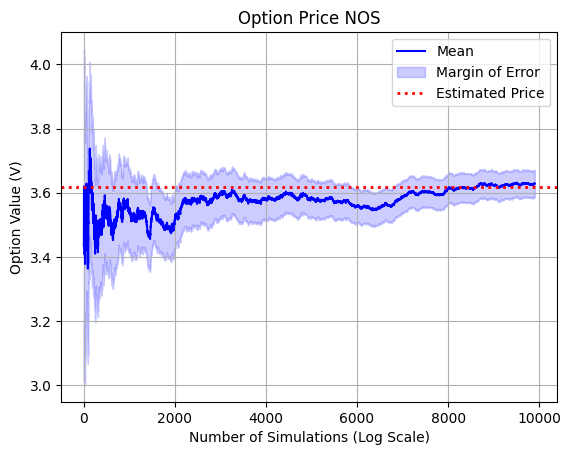

In [260]:
plot_results(new_results_basic, start = 100)

In [120]:
gbm_base = run_experiment(GBM, payoff_function = payoff_asian, simulation_size = 1000)

In [206]:
gbm_base

(array([2.70763293, 3.80374273, 3.64461611, 3.63627355, 4.09355377,
        4.04968361, 3.71892856, 3.52826167, 3.61528803, 3.65286605,
        3.64967741, 3.6259626 , 3.68301128, 3.61040671]),
 array([0.99305777, 0.87822542, 0.72375037, 0.52154662, 0.35843954,
        0.28894432, 0.18040962, 0.12815811, 0.09198251, 0.06597824,
        0.04680081, 0.0330934 , 0.02340409, 0.01646305]),
 array([1.20451450e-02, 7.29322433e-03, 2.42028236e-02, 3.65080833e-02,
        1.11340046e-01, 1.84131145e-01, 3.39143991e-01, 7.91968584e-01,
        1.46608901e+00, 2.96139145e+00, 6.43392897e+00, 1.24241977e+01,
        2.46422148e+01, 4.88187826e+01]))

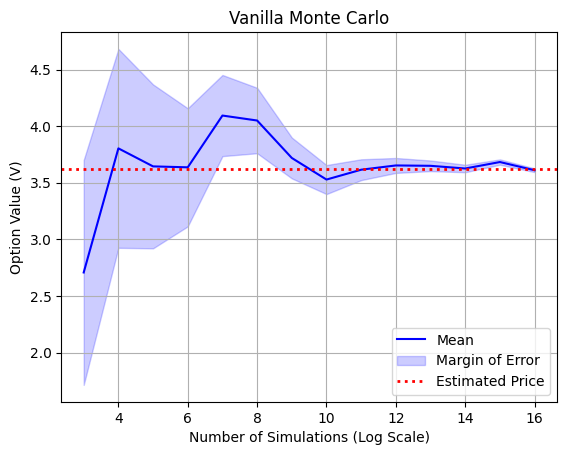

In [180]:
plot_results(gbm_base, title = "Vanilla Monte Carlo")

In [197]:
antithetic_GBM_data = run_experiment(GBM, payoff_function = payoff_asian, antithetic = True, num_trials = 17, base = 2)

In [198]:
format_data(antithetic_GBM_data)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

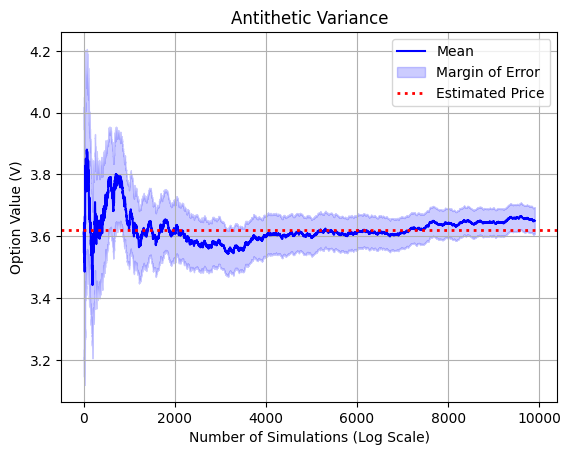

In [258]:
plot_results(antithetic_GBM_data, title = "Antithetic Variance", start = 100)

In [201]:
sobol_gbm = run_experiment(GBM, payoff_function = payoff_asian, sample_method = quasi_Sobol, num_trials = 17, base = 2)

C:\Users\starr\AppData\Local\Temp\ipykernel_16268\3577928450.py:3: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  u = sampler.random(n)


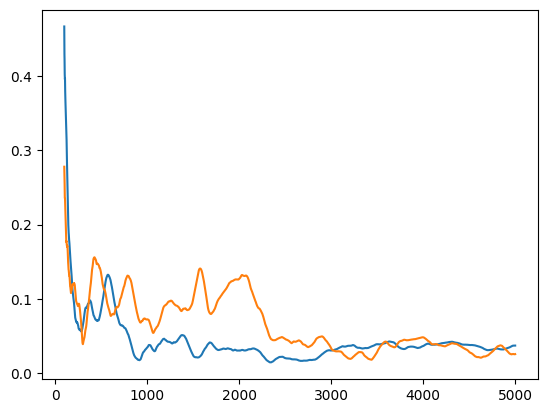

In [306]:
errs = np.abs(sobol_gbm[0] - 3.61873217)
errs = pd.Series(errs).rolling(100).mean()
mp.plot(errs[100:5000])

errs = np.abs(new_results_basic[0] - 3.61873217)
errs = pd.Series(errs).rolling(100).mean()
mp.plot(errs[100:5000])

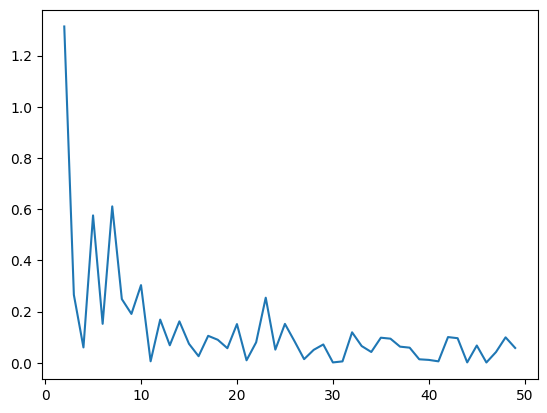

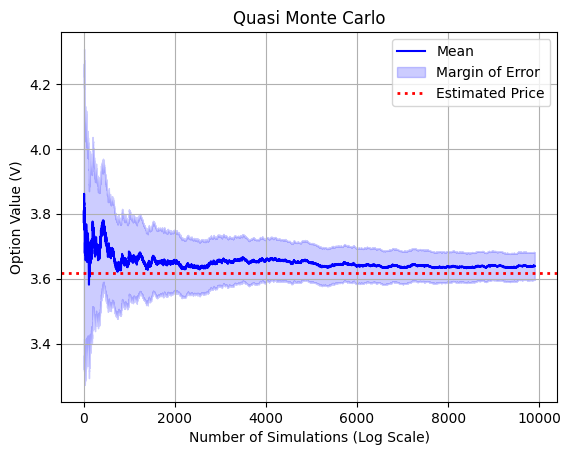

In [259]:
plot_results(sobol_gbm, "Quasi Monte Carlo", start = 100)

In [237]:
control_variates_geom = run_experiment(cv = True, num_trials = 17, base = 2)

In [149]:
format_data(control_variates_geom)

,Option Price (V),Runtime,MOE
Num Samples,,,
8,3.6761,0.0230,0.6173
16,3.6606,0.0137,0.5989
32,3.6599,0.0093,0.5805
64,3.6559,0.0058,0.5537
128,3.6509,0.0044,0.6554
256,3.6518,0.0035,0.6477
512,3.6517,0.0026,0.7200
1024,3.6504,0.0019,1.0843
2048,3.6541,0.0015,1.6170


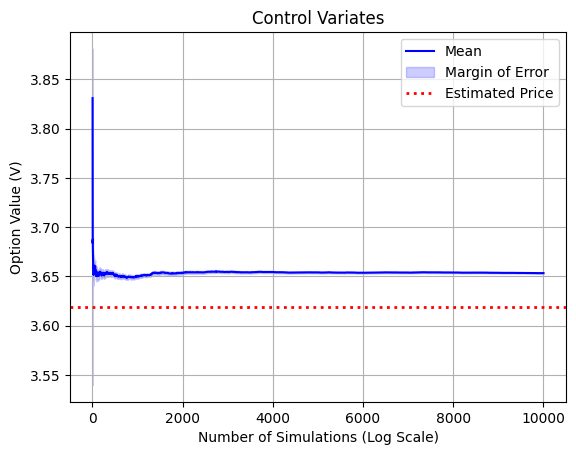

In [261]:
plot_results(control_variates_geom, title = "Control Variates")

In [213]:
importance_GBM_data = run_experiment(method=GBM_importance, 
                      payoff_function=payoff_asian_importance, 
                      sample_method = importance_sampled_normal, 
                      mu_shift=0.05, num_trials=17, base=2,
                     K = 110)

In [135]:
format_data(importance_GBM_data)

,Option Price (V),Runtime,MOE
Num Samples,,,
8,0.5715,0.2779,0.0037
16,0.1031,0.0583,0.0012
32,0.3031,0.0947,0.0035
64,0.3945,0.0841,0.0043
128,0.3969,0.0619,0.0116
256,0.3912,0.0423,0.0183
512,0.3271,0.0272,0.0309
1024,0.3613,0.0207,0.0664
2048,0.3103,0.0135,0.1503


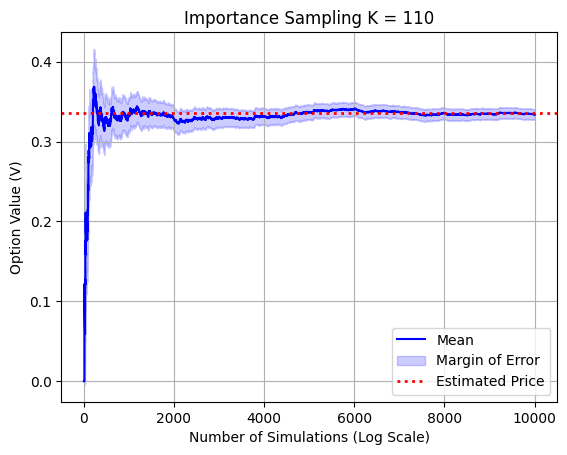

In [214]:
plot_results(importance_GBM_data, title = "Importance Sampling K = 110", true_v = 0.3359)

In [207]:
standard_gbm_K110 = run_experiment(GBM, payoff_function = payoff_asian, num_trials = 17, base = 2, K=110)

In [215]:
#format_data(standard_gbm_K110)

In [227]:
target_lengths = [10, 100, 1000, 10000]

for i in target_lengths:
    q = standard_gbm_K110[0][0:i].reshape(-1, 10).mean(axis=1)

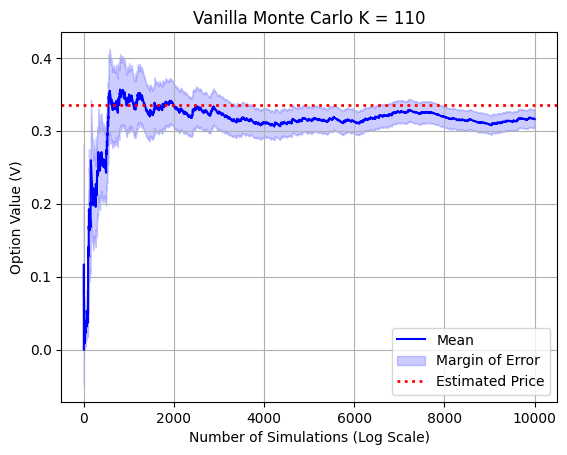

In [208]:
plot_results(standard_gbm_K110, title = "Vanilla Monte Carlo K = 110", true_v = 0.3359)

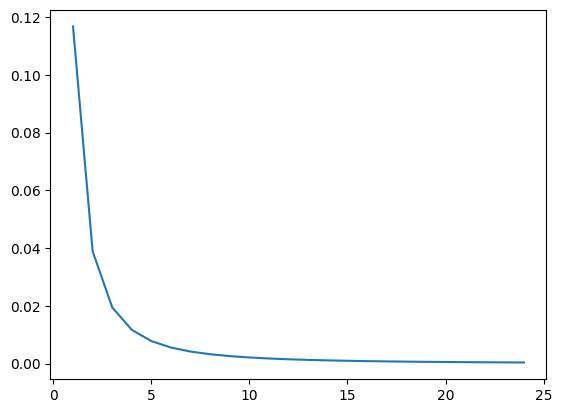

In [288]:
errs = np.abs(standard_gbm_K110[0] - 0.3359)
errs = pd.Series(errs).rolling(1).mean()
mp.plot(abs(errs.shift(1) - errs)[0:25])

In [228]:
antithetic_GBM_Sobol = run_experiment(GBM, payoff_function = payoff_asian, 
                                sample_method = quasi_Sobol,
                                antithetic = True, num_trials = 17, base = 2)

C:\Users\starr\AppData\Local\Temp\ipykernel_16268\2366309945.py:3: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  u = sampler.random(n)


In [141]:
format_data(antithetic_GBM_Sobol)

,Option Price (V),Runtime,MOE
Num Samples,,,
8,4.0188,1.0180,0.0363
16,3.4358,0.7156,0.0652
32,3.3964,0.4947,0.0723
64,3.7012,0.3419,0.1012
128,3.4774,0.2322,0.1774
256,3.7587,0.1915,0.3151
512,3.6086,0.1305,0.5215
1024,3.6211,0.0944,1.0578
2048,3.6115,0.0655,2.0836


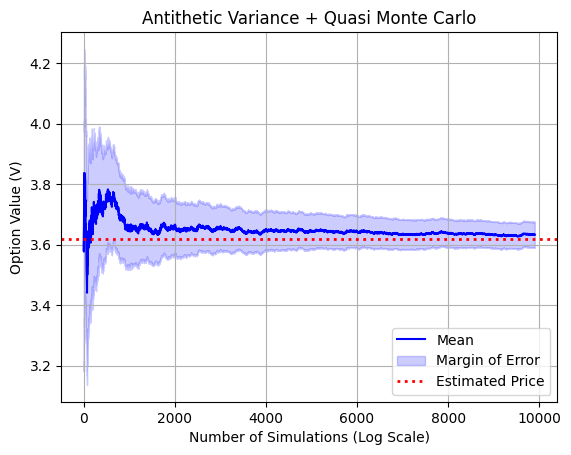

In [230]:
plot_results(antithetic_GBM_Sobol, title = "Antithetic Variance + Quasi Monte Carlo", start = 100)

In [152]:
base_method = gbm_base
reduction_methods = { 
    "AV" : antithetic_GBM_data, 
    "QMC" : sobol_gbm, 
    "CV" : control_variates_geom, 
    "AV+QMC" : antithetic_GBM_Sobol
}

In [155]:
for key in reduction_methods.keys():
    VRR = reduction_methods[key][1] / base_method[1]
    print(key + ", " + str(VRR))

AV, [1.11830198 0.80037458 0.70202356 0.72577901 0.66210667 0.63540642
 0.69347647 0.7243192  0.73248436 0.69069087 0.71042523 0.69714911
 0.70636914 0.70820716]
QMC, [1.49413996 1.28205292 1.27029802 1.04331689 0.9727849  0.93243546
 1.03775564 1.03244847 1.0251564  1.0017514  0.99774449 0.99340355
 0.99592603 1.00101899]
CV, [0.02318411 0.01559144 0.01290129 0.01106964 0.01235797 0.01198441
 0.01436533 0.01456632 0.01609035 0.01561619 0.01502382 0.01476691
 0.01466982 0.0148096 ]
AV+QMC, [1.02511771 0.81481795 0.68345454 0.65554037 0.64778356 0.66268151
 0.72331343 0.73666017 0.71254609 0.69837441 0.70387434 0.70344862
 0.70506485 0.70840199]


In [242]:
for key in reduction_methods.keys():
    VRR = reduction_methods[key][1] / base_method[1]
    print(key + ", " + str(VRR[-5:-1].mean()))

AV, 0.701158588061538
QMC, 0.99720636752047
CV, 0.015019186921411118
AV+QMC, 0.7026905545128729
